# Sentiment Analysis of Amazon's customer reviews
**Author:** Goundo Sidibe <br>
**Sources:** *https://github.com/Gsidi9/AmazonReview/blob/main/amazon_reviews%20(1).csv*<br>


## Importing the packages 


In [1]:
# ! pip install nltk
# ! pip install wordcloud
# ! pip install gensim
# ! pip install spacy
# ! pip install pyLDAvis
# !python -m spacy download en_core_web_md

In [2]:
# General packages
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

# NLP packages
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 14, 6
plt.style.use('ggplot')

We will be working with a .csv file that contains information of 580 customers writing reviews on Amazon audible membership. Each review contains textual feedback along with a 1-to-5 star rating system (1 being least satisfied and 5 being most satisfied). The following attributes are available in the data:

1. **customer (text):** register user profile name.
2. **Score (ordinal):** rating between 1 and 5.
3. **Time (numerical):** timestamp of the review.
4. **title (text):** title of the review.
5. **Text (text):** text of the review.

## Reading and performing basic analysis of the data



In [3]:

amazon_df = pd.read_csv('/Users/goundosidibe/Downloads/amazon_reviews.csv')

amazon_df.columns = ['id','customer','title','score','text','date']

amazon_df.head(5)

,id,customer,title,score,text,date
0,0,witch,One Star,1.0,"Thanks but no thanks, I'm not willing to pay t...",5 February 2017
1,1,Smith & Jones,The worst thing for me since mandatory Video w...,1.0,I dropped Amazon Prime due to the massive hike...,9 May 2017
2,2,Zahid,Love concept! But not currently value for money.,2.0,"Don't get me wrong, I am really enjoying liste...",17 January 2016
3,3,Shazebee,Imagine if Netflix used this concept. £8 for 1...,1.0,Currently trialing it but wont be continuing! ...,7 March 2017
4,4,Kieren Geaney,Good but a bit too expensive for whats on offer.,2.0,I finished a book in 2 weeks and am not allowe...,19 May 2017


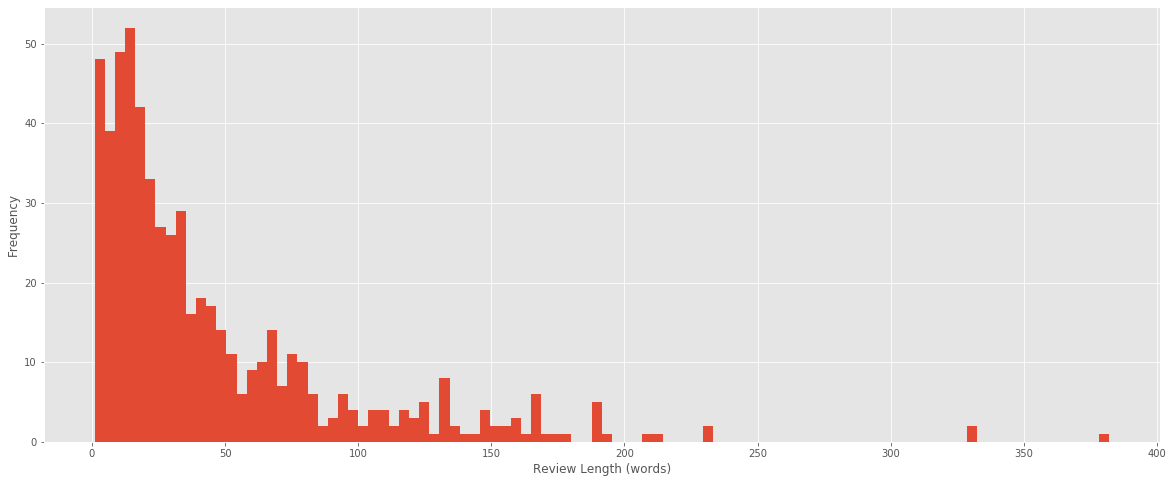

In [4]:
#looking at the distribution of number of words per review
#applying a lambda function that splits each complete review by space
words_per_review = amazon_df.text.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100, figsize=(20,8))
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show()

In [5]:
print('Average words:', words_per_review.mean())

Average words: 45.36724137931034


Users review have an average of 45 words.

In [6]:
#look at the distribution of ratings
percent_val = 100 * amazon_df['score'].value_counts()/len(amazon_df)
percent_val

1.0    51.724138
5.0    29.655172
2.0     7.586207
4.0     5.862069
3.0     5.172414
Name: score, dtype: float64

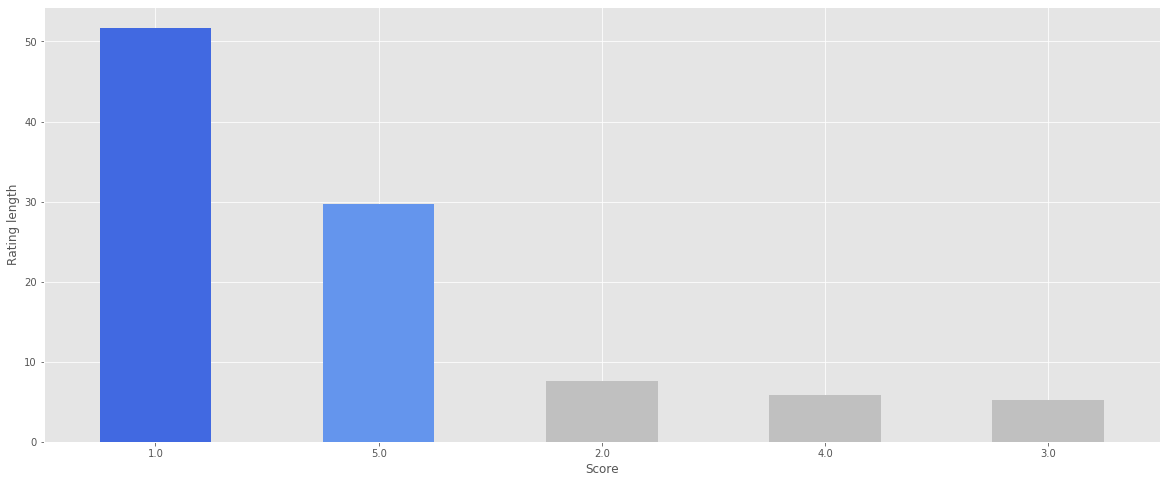

In [7]:
percent_val.plot.bar(figsize=(20,8), color=['royalblue','cornflowerblue','silver','silver','silver'])
plt.ylabel('Rating length')
plt.xticks(rotation=0,horizontalalignment="center")
plt.xlabel('Score')
plt.show()

### Text visualization using word clouds (*word clouds* )


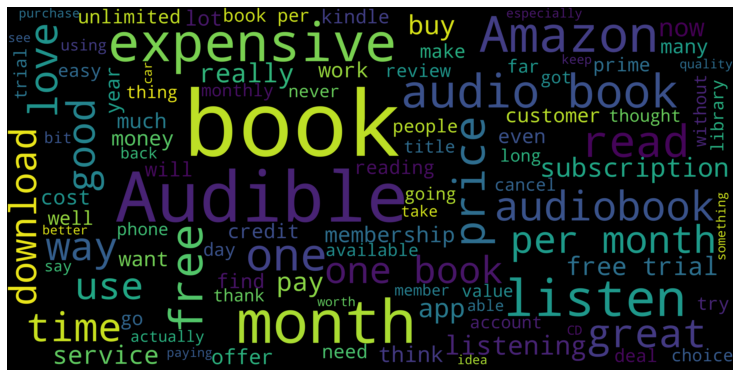

In [8]:
#looking at the distribution of the text.
#words that appear bigger have high frequency in the review.
#words that appear small have low frequency in the review.
word_cloud_text = ''.join(amazon_df['text'])

wordcloud = WordCloud(max_font_size=100, # maximum font size for the largest word
                      max_words=100, # the maximum number of words
                      background_color="black", # background color for the word cloud image
                      scale = 10, # scaling between computation and drawing
                      width=800, # width of the canvas
                      height=400 # height of the canvas
                     ).generate(word_cloud_text)

plt.figure(figsize=(13,10))
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

### Standardizing the ratings for sentiment analysis 

In [9]:
#convert all of the ratings into binary values using the follow rule.
# ratings of 4 or 5 will be mapped to 1 and will be reltead to positive reviews.
#ratings of 1 or 2 will get mapped to 0 and will be related to negative reviews.
#ratings of 3 will get removed since they will represent neutral reviews.
# Mapping the ratings
amazon_df['sentiment_rating'] = np.where(amazon_df.score > 3,1,0)

# removing neutral reviews 
amazon_df = amazon_df[amazon_df.score != 3]

# printing the counts of each class
amazon_df['sentiment_rating'].value_counts()

0    344
1    206
Name: sentiment_rating, dtype: int64

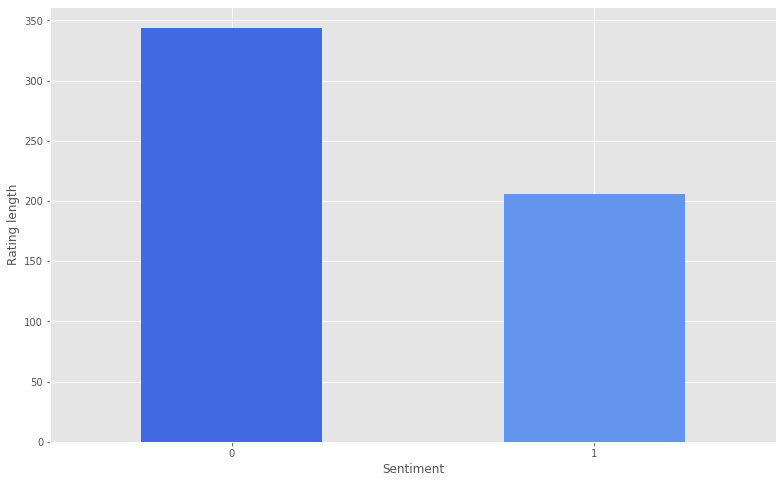

In [10]:
amazon_df.sentiment_rating.value_counts().plot.bar(figsize=(13,8),color=['royalblue','cornflowerblue'])
plt.ylabel('Rating length')
plt.xticks(rotation=0,horizontalalignment="center")
plt.xlabel('Sentiment')
plt.show()

## Pre-processing


1. Converting words to lower/upper case
2. Removing special characters
3. Removing stopwords and high/low-frequency words
4. Stemming/lemmatization

### 1. Converting words to lower/upper case



In [11]:
#converting all of the words into a consistent case format - lowercase
amazon_df['reviews_text_new'] = amazon_df['text'].str.lower()

In [12]:
from nltk import word_tokenize


In [13]:
#reviews not converted to lowercase
token_lists = [word_tokenize(each) for each in amazon_df['text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

#reviews converted to lowercase
token_lists_lower = [word_tokenize(each) for each in amazon_df['reviews_text_new']]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Number of unique tokens now: ",len(set(tokens_lower)))

Number of unique tokens then:  3480
Number of unique tokens now:  3048


The number of tokens has gone down by 12% just from normalizing the corpus.

### 2. Removing special characters

In [14]:
#The following gives a list of all the special characters in our dataset

# Selecting non alpha numeric charactes that are not spaces
spl_chars = amazon_df['reviews_text_new'].apply(lambda review: 
                                                     [char for char in list(review) if not char.isalnum() and char != ' '])

## Getting list into a single list
flat_list = [item for sublist in spl_chars for item in sublist]

## Unique special characters
set(flat_list)

{'!',
 '"',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '=',
 '>',
 '?',
 '[',
 ']',
 '_',
 '~',
 '\x9a',
 '£',
 '–',
 '‘',
 '’',
 '“',
 '”',
 '…',
 '☺',
 '🏻',
 '👍',
 '😀',
 '😊',
 '😠',
 '🤓'}

In [15]:
#Removing the special characters from the reviews by applying a regular expression
review_backup = amazon_df['reviews_text_new'].copy()
amazon_df['reviews_text_new'] = amazon_df['reviews_text_new'].str.replace(r'[^A-Za-z0-9 ]+', ' ')

In [16]:
#seeing how our reviews change after removing these:
print("- Old Review -")
print(review_backup.values[6])
print("\n- New Review -")
print(amazon_df['reviews_text_new'][6])

- Old Review -
don't subscribe to audible books they are still taking money from my account years after finishing with them. the fraud squad from my bank are forcing them to return money they take every month!

- New Review -
don t subscribe to audible books they are still taking money from my account years after finishing with them  the fraud squad from my bank are forcing them to return money they take every month 


In [17]:
#checking if the number of unique tokens has dropped further
token_lists = [word_tokenize(each) for each in amazon_df['text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

token_lists = [word_tokenize(each) for each in amazon_df['reviews_text_new']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens now: ",len(set(tokens)))

Number of unique tokens then:  3480
Number of unique tokens now:  2746


### 3. Stopwords and high/low frequency words

In [18]:
from nltk.corpus import stopwords
# reviewing what languages are available in the nltk package
print('Available languages for NLTK v.3.4.5: ')
print(stopwords.fileids())

Available languages for NLTK v.3.4.5: 
['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


In [19]:
#reviewing the list of English stopwords
noise_words = []
eng_stop_words = stopwords.words('english')
eng_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [20]:
#testing the stopword

stop_words = set(eng_stop_words)
without_stop_words = []
stopword = []
sentence = amazon_df['reviews_text_new'][0]
words = nltk.word_tokenize(sentence)

for word in words:
    if word in stop_words:
        stopword.append(word)
    else:
        without_stop_words.append(word)

print('-- Original Sentence --\n', sentence)
print('\n-- Stopwords in the sentence --\n', stopword)
print('\n-- Non-stopwords in the sentence --\n', without_stop_words)

-- Original Sentence --
 thanks but no thanks  i m not willing to pay this monthly sum  far too expensive 

-- Stopwords in the sentence --
 ['but', 'no', 'i', 'm', 'not', 'to', 'this', 'too']

-- Non-stopwords in the sentence --
 ['thanks', 'thanks', 'willing', 'pay', 'monthly', 'sum', 'far', 'expensive']


In [21]:
#omitting the stopwords to the reviews:

def stopwords_removal(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

amazon_df['reviews_text_nonstop'] = amazon_df['reviews_text_new'].apply(lambda row: stopwords_removal(stop_words, row))
amazon_df[['reviews_text_new','reviews_text_nonstop']]

,reviews_text_new,reviews_text_nonstop
0,thanks but no thanks i m not willing to pay t...,"[thanks, thanks, willing, pay, monthly, sum, f..."
1,i dropped amazon prime due to the massive hike...,"[dropped, amazon, prime, due, massive, hike, p..."
2,don t get me wrong i am really enjoying liste...,"[get, wrong, really, enjoying, listening, audi..."
3,currently trialing it but wont be continuing ...,"[currently, trialing, wont, continuing, 7, 99,..."
4,i finished a book in 2 weeks and am not allowe...,"[finished, book, 2, weeks, allowed, another, n..."
...,...,...
575,a brilliant resource especially for encouragin...,"[brilliant, resource, especially, encouraging,..."
576,simple to use and good quality though i think ...,"[simple, use, good, quality, though, think, bo..."
577,great to listen in bed without having to sit u...,"[great, listen, bed, without, sit, bed]"
578,amazing wide variety of titles and subjects,"[amazing, wide, variety, titles, subjects]"


### 4. Stemming & lemmatization

**Stemming** works by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found.

**Lemmatization** takes into consideration the morphological analysis of the words. So lemmatization considers the grammar of the word and tries to find the root word instead of just getting to the root word by brute force methods.

In [22]:
from nltk.stem import PorterStemmer, LancasterStemmer 
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/goundosidibe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Building a machine learning model

In [23]:
amazon_df[['text','score','sentiment_rating']].head(5)

,text,score,sentiment_rating
0,"Thanks but no thanks, I'm not willing to pay t...",1.0,0
1,I dropped Amazon Prime due to the massive hike...,1.0,0
2,"Don't get me wrong, I am really enjoying liste...",2.0,0
3,Currently trialing it but wont be continuing! ...,1.0,0
4,I finished a book in 2 weeks and am not allowe...,2.0,0


### Bag-of-words and n-grams

In [24]:
#using n-grams to retains the structure of the overall document, and
#paves the way for analyzing words in context. 

from nltk import ngrams


#using bag of words to analyse the frequency of a word appearing in the text.
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(amazon_df['reviews_text_new'])
df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df.head()

,00,10,100,109,11,12,128kbps,13,15,16,...,yes,yesterday,yet,you,younger,your,yourself,youtube,yuval,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0


In [25]:
#creating a python object of the class CountVectorizer

bow_counts = CountVectorizer(tokenizer= word_tokenize,
                             ngram_range=(1,4))

bow_data = bow_counts.fit_transform(amazon_df.reviews_text_new)

In [26]:
bow_data

<550x60555 sparse matrix of type '<class 'numpy.int64'>'
	with 90809 stored elements in Compressed Sparse Row format>

A parse matrix of 550 observations (number of rows of the reviews_text_new series) has been built, and 2746 columns corresponding to the features extracted by means of the representation of the 1-gram count of the user reviews.

## Split data into train dataset and test dataset

In [27]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data, # Features
                                                                    amazon_df['sentiment_rating'], # Target variable
                                                                    test_size = 0.2, # 20% test size
                                                                    random_state = 0) # random state for replication purposes

In [28]:
y_test_bow.value_counts()/y_test_bow.shape[0]

0    0.636364
1    0.363636
Name: sentiment_rating, dtype: float64

## Logistic Regression Model Fitting

In [29]:

lr_model_all_new = LogisticRegression(max_iter = 200)
lr_model_all = LogisticRegression() 
# fit the model with data
lr_model_all_new.fit(X_train_bow, y_train_bow)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:

#Predicting the test dataset and calculating the accuracy

# Predicting the results
test_pred_lr_all = lr_model_all_new.predict(X_test_bow)

## Calculate key performance metrics

print("Accuracy of logistic regression classifier on test dataset: ", f1_score(y_test_bow, test_pred_lr_all))

Accuracy of logistic regression classifier on test dataset:  0.85


## Model Evaluation using Confusion Matrix

In [31]:
#Using confusion matric to  visualize the performance of an algorithm. 
#The fundamental of a confusion matrix is the number of correct and incorrect predictions are summed up class-wise.

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_bow, test_pred_lr_all)
print(confusion_matrix)


[[64  6]
 [ 6 34]]


The confusion matrix in the form of the array object. The dimension of this matrix is 2*2 because this model is binary classification. You have two classes 0 and 1. Diagonal values represent accurate predictions, while non-diagonal elements are inaccurate predictions. In the output, 64 and 6 are actual predictions, and 6 and 34 are incorrect predictions.

Text(0.5, 257.44, 'Predicted label')

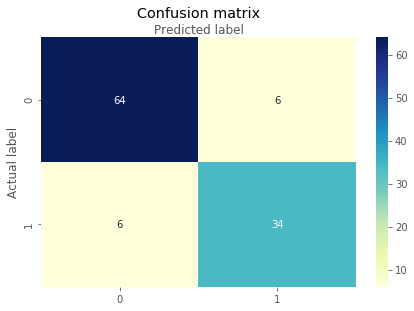

In [32]:
#visualize the results of the model in the form of a confusion matrix using matplotlib and seaborn.
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [33]:
#evaluating the model using model evaluation metrics such as accuracy, precision, and recall.

# print("Accuracy:",metrics.accuracy_score(y_test_bow, test_pred_lr_all))
# print("Precision:",metrics.precision_score(y_test_bow, test_pred_lr_all))
# print("Recall:",metrics.recall_score(y_test_bow, test_pred_lr_all))

# Top 15 words in  positive reviews

In [34]:
# # Import package
from wordcloud import WordCloud, STOPWORDS


lr_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names(), # ge tall the n-gram feature names
                                   lr_model_all_new.coef_[0])), # get the logistic regression coefficients
                          columns= ['words','weights']) # defining the colunm names

# # top-15 more important features for negative reviews
top =lr_weights.sort_values(['weights'], ascending = False) # top-15 more important features for positive reviews
top.head(15)

,words,weights
22062,great,1.099871
31050,love,0.787286
17998,excellent,0.771549
21740,good,0.612601
11474,brilliant,0.608434
10714,books,0.560300
56244,very good,0.500478
16971,easy,0.396199
27834,it,0.372567
30415,listening,0.352136


In [35]:


# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

# Top 15 words in  negative reviews

In [36]:
l_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names(), # ge tall the n-gram feature names
                                   lr_model_all_new.coef_[0])), # get the logistic regression coefficients
                          columns= ['words','weights']).sort_values(['weights'], ascending = True) # defining the colunm names



# bottom=l_weights.sort_values(['weights'], ascending = True)# top-15 most important features for negative reviews
# bottom.head(15)


l_weights.head(15)

,words,weights
18147,expensive,-1.272977
54025,too,-0.913274
54059,too expensive,-0.892320
35213,not,-0.765285
34940,no,-0.544487
32743,month,-0.504946
59272,worst,-0.497250
39062,overpriced,-0.445470
4161,amazon,-0.412051
55147,unlimited,-0.398737


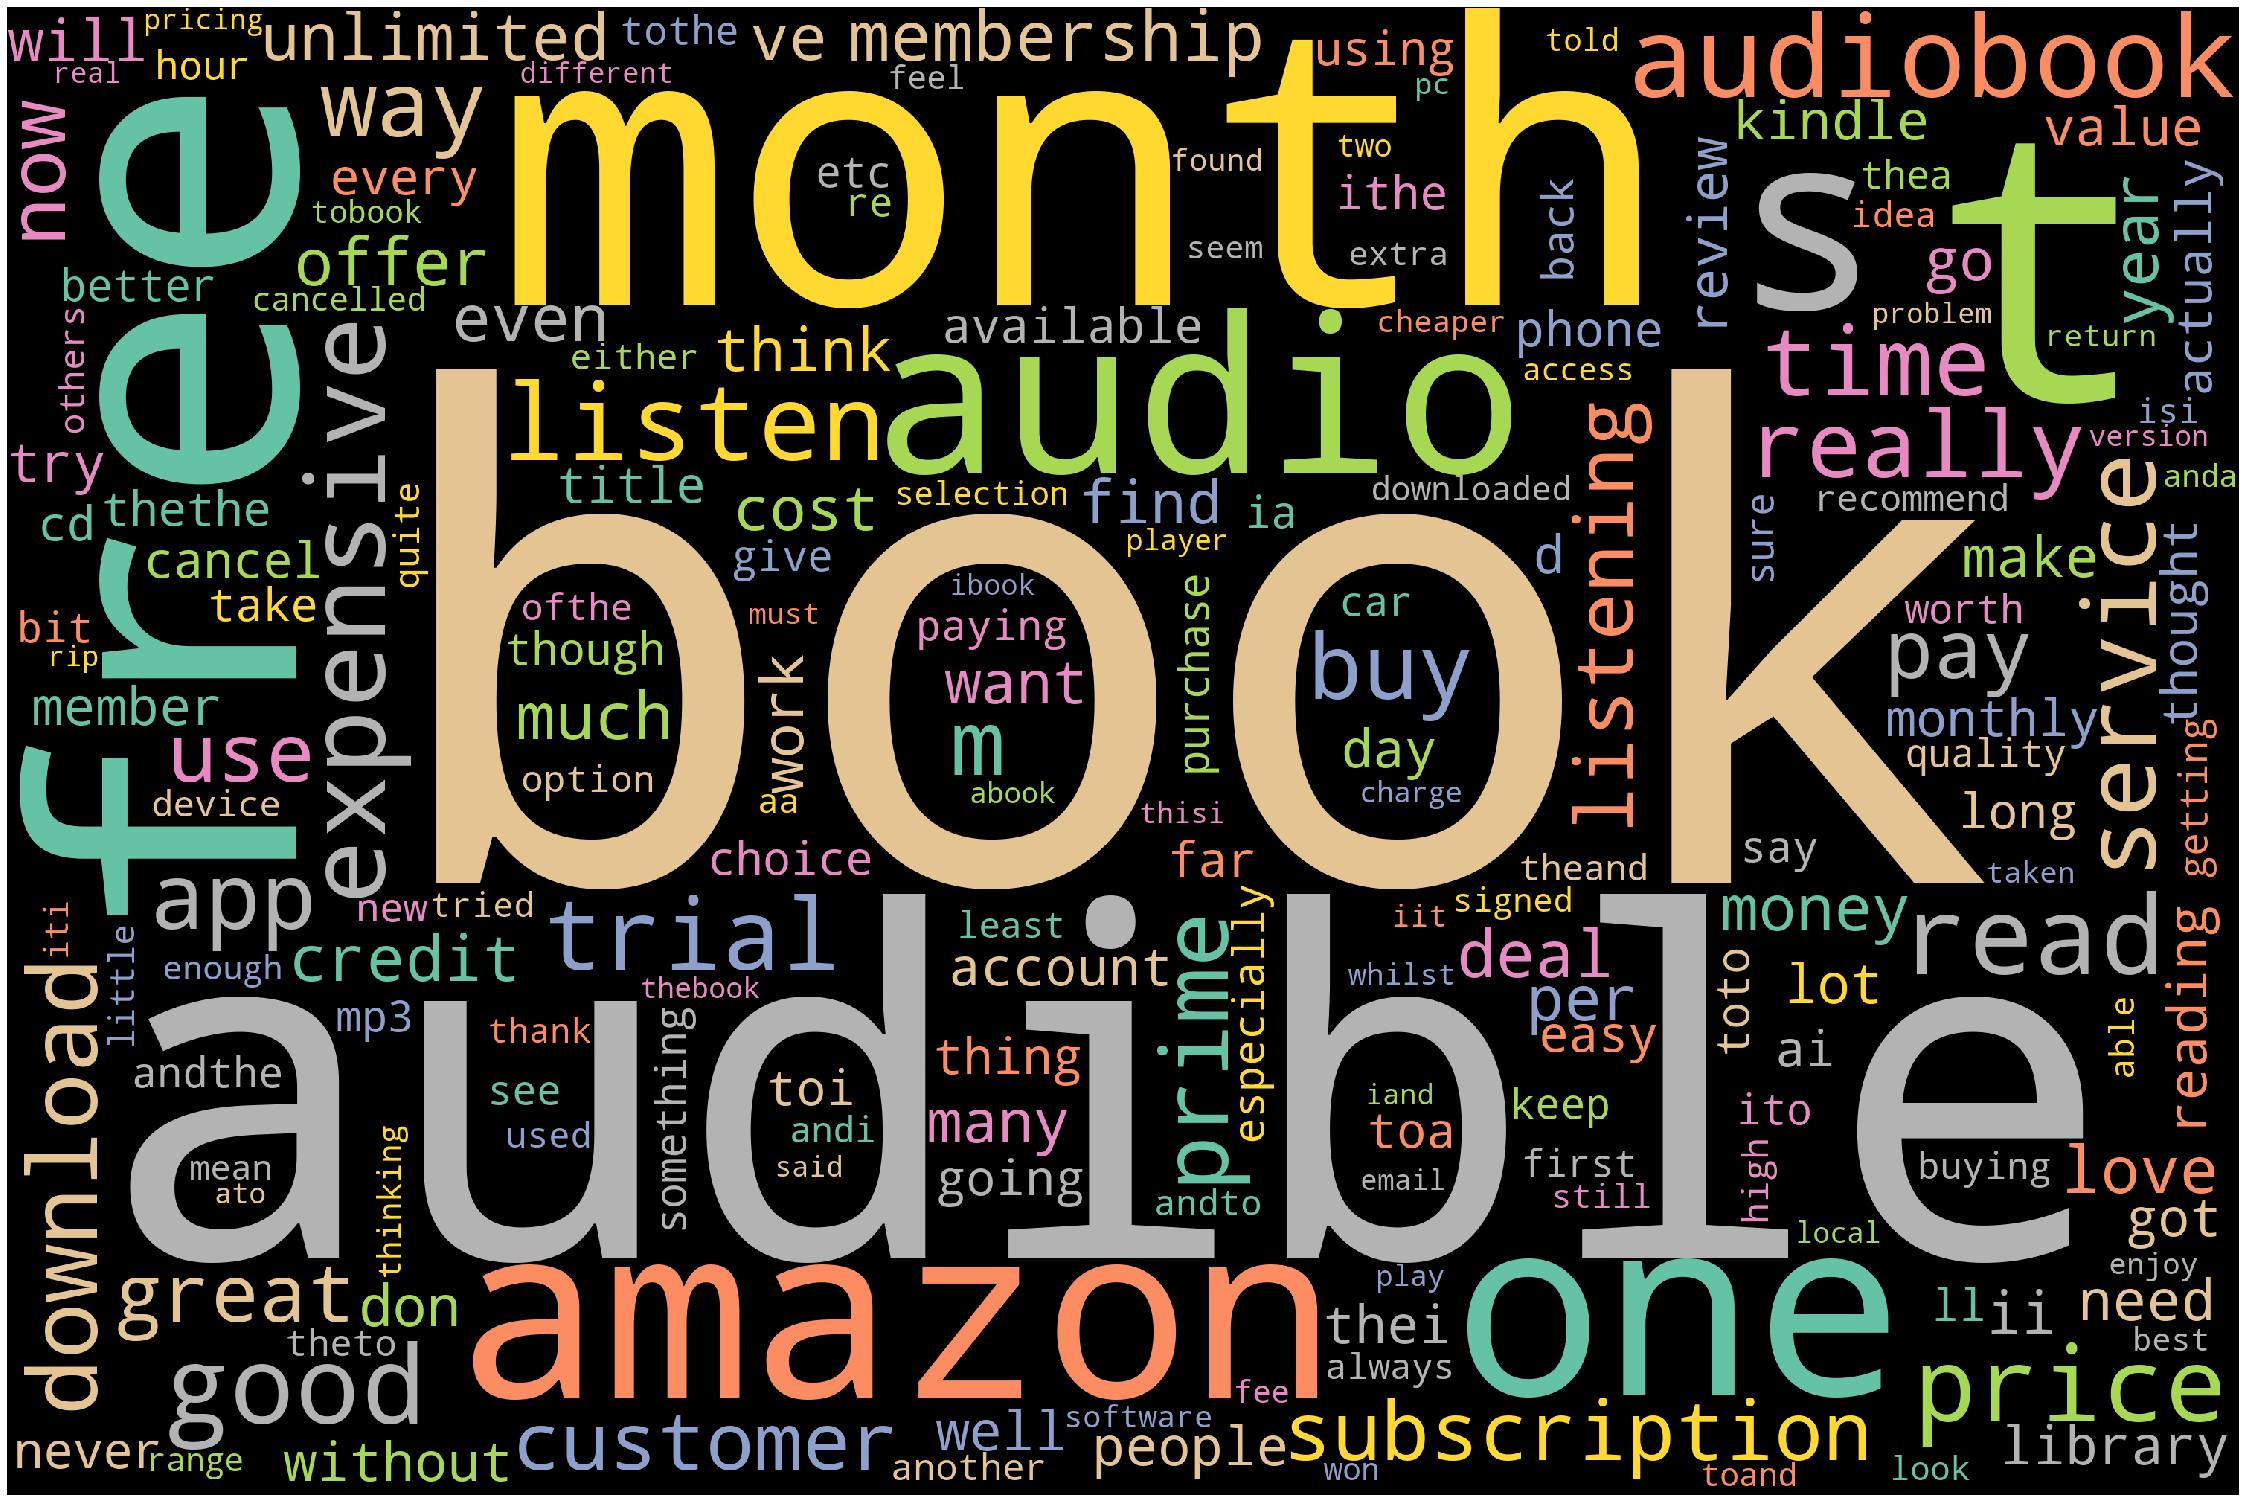

In [37]:
word_cloud_text = ''.join(l_weights['words'])


# Generate wordcloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(word_cloud_text)
# Plot
plot_cloud(wordcloud)

In [42]:
import re
import string

import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [54]:
# amazon_df['text'] = amazon_df['text'].apply(clean_text)
amazon_df['Num_words_text'] = amazon_df['text'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(amazon_df['score'].value_counts())
print(len(amazon_df))
print('-------------------------')
max_review_data_sentence_length  = amazon_df['Num_words_text'].max()

mask = (amazon_df['Num_words_text'] < 10) & (amazon_df['Num_words_text'] >=2)
df_short_reviews = amazon_df[mask]
df_sampled = df_short_reviews.groupby('score').apply(lambda x: x.sample(n=3)).reset_index(drop = True)



-------Dataset --------
1.0    300
5.0    172
2.0     44
4.0     34
Name: score, dtype: int64
550
-------------------------


In [55]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
df_sampled['text']=df_sampled['text'].apply(remove_stopwords)

In [56]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [57]:
text_list=df_sampled['text'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

1 book month good price
['book', 'month', 'good', 'price']


In [58]:
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [59]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [60]:
lda_model.print_topics()

[(0,
  '0.256*"variation" + 0.256*"enough" + 0.256*"content" + 0.023*"great" + 0.023*"drive" + 0.023*"fantastic" + 0.023*"service" + 0.023*"expensive" + 0.023*"good" + 0.023*"month"'),
 (1,
  '0.721*"expensive" + 0.023*"variation" + 0.023*"great" + 0.023*"drive" + 0.023*"fantastic" + 0.023*"service" + 0.023*"enough" + 0.023*"good" + 0.023*"price" + 0.023*"book"'),
 (2,
  '0.208*"month" + 0.208*"price" + 0.208*"book" + 0.208*"good" + 0.019*"fantastic" + 0.019*"enough" + 0.019*"great" + 0.019*"drive" + 0.019*"expensive" + 0.019*"variation"'),
 (3,
  '0.333*"book" + 0.333*"service" + 0.030*"enough" + 0.030*"great" + 0.030*"drive" + 0.030*"fantastic" + 0.030*"expensive" + 0.030*"variation" + 0.030*"good" + 0.030*"month"'),
 (4,
  '0.077*"fantastic" + 0.077*"expensive" + 0.077*"good" + 0.077*"book" + 0.077*"service" + 0.077*"great" + 0.077*"drive" + 0.077*"enough" + 0.077*"month" + 0.077*"price"'),
 (5,
  '0.488*"good" + 0.256*"expensive" + 0.023*"service" + 0.023*"great" + 0.023*"drive" + 

In [61]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.007378  0.190551       1        1  20.070103
8      0.121389 -0.129651       2        1  17.701750
0      0.100055 -0.069072       3        1  15.070171
5     -0.181792  0.030879       4        1  12.877056
1     -0.212012 -0.103899       5        1  11.122992
3      0.075070  0.112799       6        1  10.245635
9      0.026167 -0.007902       7        1   3.228072
7      0.026167 -0.007902       8        1   3.228072
6      0.026167 -0.007902       9        1   3.228072
4      0.026167 -0.007902      10        1   3.228072, topic_info=   Category     Freq       Term     Total  loglift  logprob
0   Default  2.00000  expensive  2.000000  13.0000  13.0000
2   Default  2.00000       good  2.000000  12.0000  12.0000
1   Default  1.00000       book  1.000000  11.0000  11.0000
8   Default  1.00000    service  1.000000  10.0000  10.0000
5   Default  1.00000    content  1.000000   9.0000   9.0000
..      ...      ...        ...       ...      ...      ...
4   Topic10  0.04718      price  1.275248   0.1363  -2.5649
3   Topic10  0.04718      month  1.275248   0.1363  -2.5649
1   Topic10  0.04718       book  1.865147  -0.2439  -2.5649
2   Topic10  0.04718       good  2.413228  -0.5015  -2.5649
0   Topic10  0.04718  expensive  2.599170  -0.5757  -2.5649

[143 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1         1  0.536151       book
1         6  0.536151       book
5         3  0.818569    content
10        2  0.840094      drive
6         3  0.818569     enough
0         4  0.384738  expensive
0         5  0.769476  expensive
9         2  0.840094  fantastic
2         1  0.414383       good
2         4  0.414383       good
11        2  0.840094      great
12        2  0.840094       long
3         1  0.784161      month
4         1  0.784161      price
8         6  0.872865    service
7         3  0.818569  variation, R=13, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 1, 6, 2, 4, 10, 8, 7, 5])

In [62]:

print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)




Perplexity:  -2.9535717069453375

Coherence Score:  0.5414259101325393


In [63]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [64]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
    corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

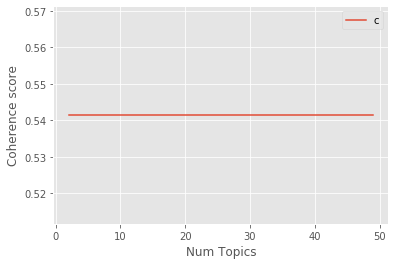

In [65]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [66]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5414
Num Topics = 3  has Coherence Value of 0.5414
Num Topics = 4  has Coherence Value of 0.5414
Num Topics = 5  has Coherence Value of 0.5414
Num Topics = 6  has Coherence Value of 0.5414
Num Topics = 7  has Coherence Value of 0.5414
Num Topics = 8  has Coherence Value of 0.5414
Num Topics = 9  has Coherence Value of 0.5414
Num Topics = 10  has Coherence Value of 0.5414
Num Topics = 11  has Coherence Value of 0.5414
Num Topics = 12  has Coherence Value of 0.5414
Num Topics = 13  has Coherence Value of 0.5414
Num Topics = 14  has Coherence Value of 0.5414
Num Topics = 15  has Coherence Value of 0.5414
Num Topics = 16  has Coherence Value of 0.5414
Num Topics = 17  has Coherence Value of 0.5414
Num Topics = 18  has Coherence Value of 0.5414
Num Topics = 19  has Coherence Value of 0.5414
Num Topics = 20  has Coherence Value of 0.5414
Num Topics = 21  has Coherence Value of 0.5414
Num Topics = 22  has Coherence Value of 0.5414
Num Topics = 23  has 